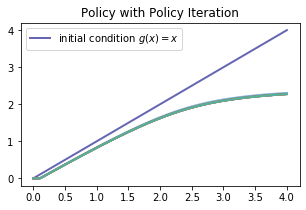

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d



def policy_iteration(g, grid, β, r_prime,ϕ, ϕ_prime, shocks, Kg=None):
    
    # === Apply linear interpolation to g === #
    g_func = lambda x: np.interp(x, grid, g)

    # == Initialize Kg if necessary == #
    if Kg is None:
        Kg = np.empty_like(g)

    # == solve for updated consumption value

    for i, x in enumerate(grid):
        def h(u):
            vals = r_prime(g_func(ϕ(x - u) * shocks)) * ϕ_prime(x - u) * shocks
            return r_prime(u) - β * np.mean(vals)
        u_star = brentq(h, -2.5+1e-10, x - 1e-10)
        if u_star < 0:
            u_star = 0

        Kg[i] = u_star

    return Kg

β = 0.90
α = 0.25
r_prime = lambda k: (5-2*k)

ϕ= lambda k: k**α
ϕ_prime=lambda k: α*k**(α-1)
grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.random.lognormal(0,0.25,shock_size)

g = grid

n = 10
fig, ax = plt.subplots(figsize=(5, 3))
lb = 'initial condition $g(x) = x$'
ax.plot(grid, g, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
for i in range(n):
    new_g = policy_iteration(g, grid, β, r_prime, ϕ, ϕ_prime, shocks)
    g = new_g
    ax.plot(grid, g, lw=2, alpha=0.6)

ax.legend()
ax.set_title("Policy with Policy Iteration")

plt.show()

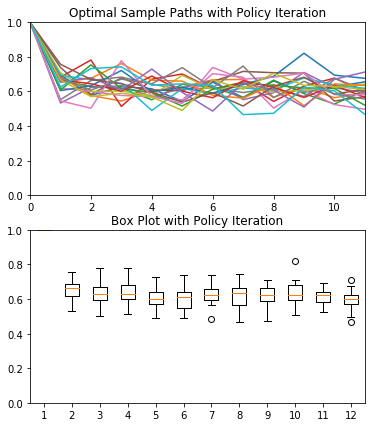

In [34]:
T = 10
M = 20             # number of sample paths

def ForwardPass(c_star):
    consumption=lambda xvals,ygrid: np.interp(xvals,grid,ygrid)
    s=np.ones(T+2)
    s[0]=1
    psi = np.random.lognormal(0,0.1,T+1)
    for t in np.arange(T+1):
        if consumption(s[t],c_star[t]) < s[t]:
            s[t+1]=psi[t]*(s[t]-consumption(s[t],c_star[t]))**α
        else:
            s[t+1]= 0  
    return s    
     
    
# Approximate Backward Recursion with Policy Iteration 

c_star=np.zeros([T+1,grid_size])
g_star = np.zeros([T+1,grid_size])
g_func = lambda x,y: np.interp(x, grid, y)

for t in np.arange(T,-1,-1):
    
    if t==T:
        for i,s in enumerate(grid):
            def h(u):
                vals = r_prime(ϕ(s - u) * shocks) * ϕ_prime(s - u) * shocks
                return r_prime(u) - β * np.mean(vals)
            u_star = brentq(h, -2.5+1e-10, s - 1e-10)
            c_star[-1,i] = u_star*(u_star>=0)
            g_star[-1,i] = c_star[-1,i]
    else:
        for i,s in enumerate(grid):
            def h(u):
                vals = r_prime(g_func(ϕ(s - u) * shocks,g_star[t+1,:])) * ϕ_prime(s - u) * shocks
                return r_prime(u) - β * np.mean(vals)
            u_star = brentq(h, -2.5+1e-10, s - 1e-10)
            c_star[t,i] = u_star*(u_star>=0)
            g_star[t,i] = c_star[t,i]

# Simulation of optimal paths

SamplePaths=np.zeros([M,T+2])
for i in range(M):
    SamplePaths[i,:]=ForwardPass(c_star)
    
fig,ax = plt.subplots(2,1,figsize=(6,7))

for i in range(M):
    ax[0].plot(SamplePaths[i])
ax[0].set_xlim([0,T+1])
ax[0].set_ylim([0,1])
ax[0].set_title("Optimal Sample Paths with Policy Iteration")

ax[1].boxplot(SamplePaths)
ax[1].set_ylim([0,1])
ax[1].set_title("Box Plot with Policy Iteration")
plt.show()

In [1]:
grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.random.lognormal(0,0.25,shock_size)

def ForwardPass(c_star):
    consumption=lambda xvals,ygrid: np.interp(xvals,grid,ygrid)
    s=np.ones(T+2)
    s[0]=1
    psi = np.random.lognormal(0,0.1,T+1)
    for t in np.arange(T+1):
        if consumption(s[t],c_star[t]) < s[t]:
            s[t+1]=psi[t]*(s[t]-consumption(s[t],c_star[t]))**α
        else:
            s[t+1]= 0  
    return s    
    
    
# Approximate Backward Recursion with Value Iteration 

c_star=np.zeros([T+1,grid_size])
v_star=np.zeros([T+1,grid_size])
v_func = lambda x,y: np.interp(x, grid, y)

for t in np.arange(T,-1,-1):
    
    if t==T:
        for i,s in enumerate(grid):
            objective = lambda c: -c*(5-c)
            c_star[-1,i]=fminbound(objective,0,s)
            v_star[-1,i]=-objective(c_star[-1,i])
    else:
        for i,s in enumerate(grid):
            objective = lambda c: -c*(5-c)-β*np.mean(v_func(shocks*(s-c)**α,v_star[t+1,:]))            
            c_star[t,i]=fminbound(objective,0,s)
            v_star[t,i]=-objective(c_star[-1,i])


# Simulation of optimal paths

SamplePaths=np.zeros([M,T+2])
for i in range(M):
    SamplePaths[i,:]=ForwardPass(c_star)
    
fig,ax = plt.subplots(2,1,figsize=(6,7))

for i in range(M):
    ax[0].plot(SamplePaths[i])
ax[0].set_xlim([0,T+1])
ax[0].set_ylim([0,1])
ax[0].set_title("Optimal Sample Paths with Value Iteration")

ax[1].boxplot(SamplePaths)
ax[1].set_ylim([0,1])
ax[1].set_title("Box Plot with Value Iteration")
plt.show()

NameError: name 'np' is not defined